In [9]:
# Import necessary libraries
import cdflib
import xarray as xr

import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm
from dateutil import parser

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade


In [15]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Soumya_GRACE_Fountain_effect/'

f = 'GRACE_data/df_sel.csv'
df = pd.read_csv(path+f)
print(df.columns)

time = [parser.parse(i) for i in df['index']]
df['gps_time'] = time

Index(['index', 'alt', 'gps_time', 'lat', 'lon', 'qualflg', 'xpos', 'xpos_err',
       'xvel', 'xvel_err', 'ypos', 'ypos_err', 'yvel', 'yvel_err', 'zpos',
       'zpos_err', 'zvel', 'zvel_err', 'mlt'],
      dtype='object')


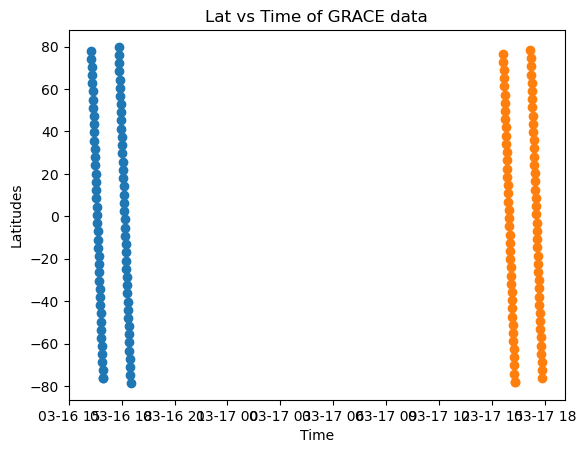

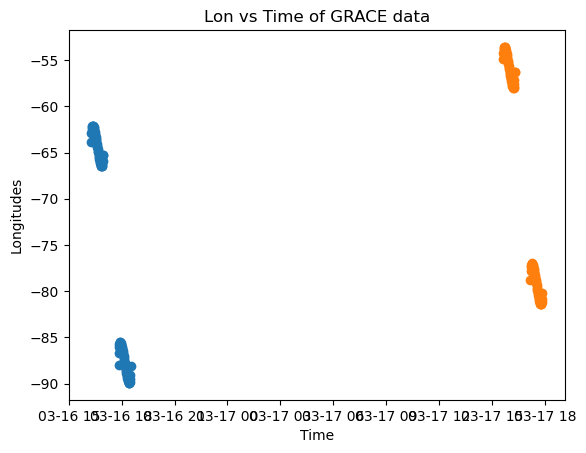

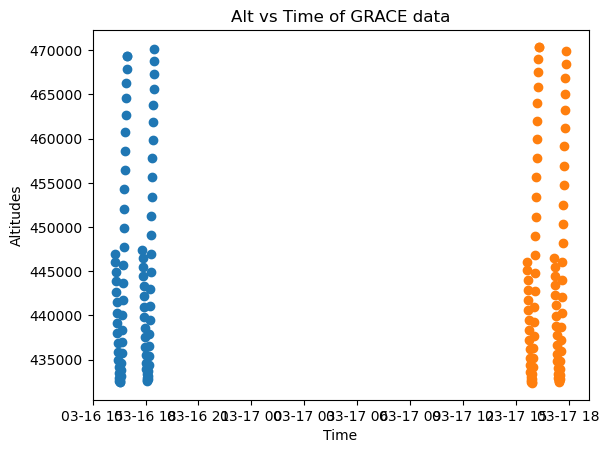

In [38]:
grace_pos1 = df[((df.gps_time > parser.parse('16-03-2013 12:00:00')) & (df.gps_time < parser.parse('17-03-2013 00:00:00')))].reset_index(drop=True)
grace_pos2 = df[(df.gps_time > parser.parse('17-03-2013 12:00:00'))].reset_index(drop=True)


plt.figure()
plt.scatter(grace_pos1.gps_time, grace_pos1.lat)
plt.scatter(grace_pos2.gps_time, grace_pos2.lat)
plt.xlabel('Time')
plt.ylabel('Latitudes')
plt.title('Lat vs Time of GRACE data')
plt.show()

plt.figure()
plt.scatter(grace_pos1.gps_time, grace_pos1.lon)
plt.scatter(grace_pos2.gps_time, grace_pos2.lon)
plt.xlabel('Time')
plt.ylabel('Longitudes')
plt.title('Lon vs Time of GRACE data')
plt.show()

plt.figure()
plt.scatter(grace_pos1.gps_time, grace_pos1.alt)
plt.scatter(grace_pos2.gps_time, grace_pos2.alt)
plt.xlabel('Time')
plt.ylabel('Altitudes')
plt.title('Alt vs Time of GRACE data')
plt.show()

In [31]:
# Function for rays along Line of sight from Grace to GPS satellite

def line_of_sight_calc(start, end, #start and end pts
                       num_points=50, # number of points 
                       base = 4, # Adjust base of log to get required point density
                       spacing='log'): # currently supports log & linear
    # Calculate direction vector
    direction = np.array(end) - np.array(start)
    
    if spacing == 'log':
        # see below for a discussion on why I did this
        deltas = np.geomspace(0.00001, 1, num=num_points) ** (base/10)
    
    elif spacing == 'linear':
        deltas = np.linspace(0, 1, num=num_points)
        
    else:
        raise ValueError
    
    # Scale and translate values to fit the line segment
    points = [start + t * direction for t in deltas]

    return points

[42]


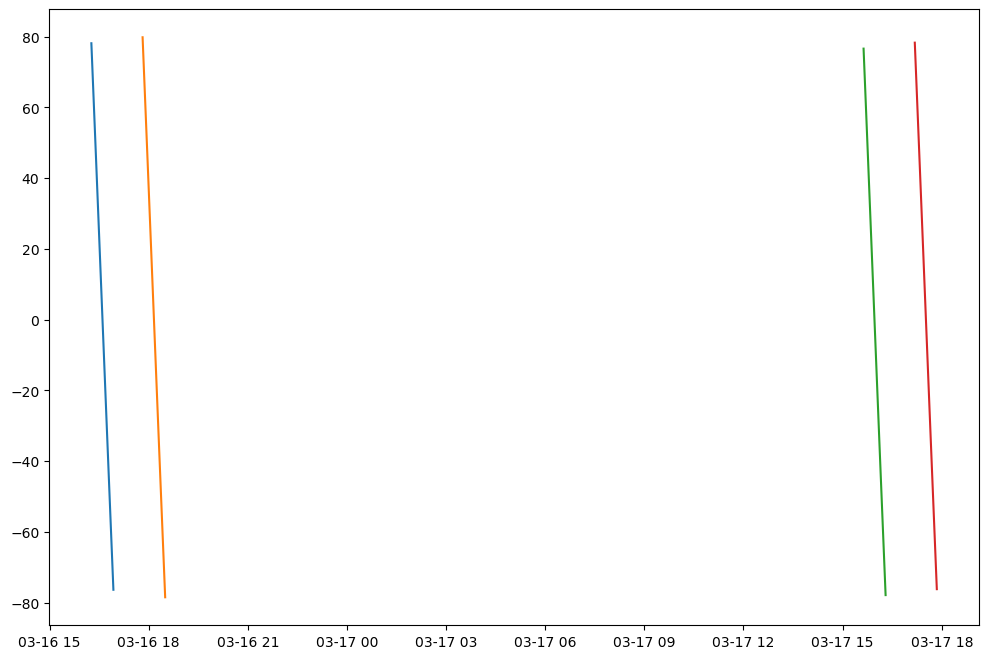

In [44]:
peaks, _ = find_peaks(grace_pos1.lat.abs())
print(peaks)
orbit1 = grace_pos1[grace_pos1.index < peaks[0]].reset_index(drop=True)
orbit2 = grace_pos1[grace_pos1.index >= peaks[0]].reset_index(drop=True)

peaks, _ = find_peaks(grace_pos2.lat.abs())
orbit3 = grace_pos2[grace_pos2.index < peaks[0]].reset_index(drop=True)
orbit4 = grace_pos2[grace_pos2.index >= peaks[0]].reset_index(drop=True)

orbits = [orbit1, orbit2, orbit3, orbit4]

plt.figure(figsize=(12,8))
plt.plot(orbit1.gps_time, orbit1.lat)
plt.plot(orbit2.gps_time, orbit2.lat)
plt.plot(orbit3.gps_time, orbit3.lat)
plt.plot(orbit4.gps_time, orbit4.lat)

In [54]:
import sys
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')
import ecef_geodetic

for o in orbits:
    a = [0]*len(o.alt)
    grace_coord = [o.lat, o.lon, o.alt]
    ground_coord = [o.xpos, o.ypos, a]
        
    ray = line_of_sight_calc(grace_coord, ground_coord)

    points = []
    for r in ray:
        lat_r, lon_r, alt_r = r
        x_r = []
        y_r = []
        z_r = []
        for la, lo, al in zip(lat_r, lon_r, alt_r):
            x, y, z = ecef_geodetic.spher_cart(la,lo,al)
            x_r.append(x)
            y_r.append(y)
            z_r.append(z)
        points.append(np.array([x_r, y_r, z_r]))

df_raypaths = pd.DataFrame()
df_raypaths['lat'] = points[:,:,0].flatten()
df_raypaths['lon'] = points[:,:,1].flatten()
df_raypaths['alt'] = points[:,:,2].flatten() / 1000


path = '/home/pxv220016/scratch/'
csv_name = path + 'multiorbit_data/single_orbit_los_' + str(orbit_num) + '.csv'
csv_raw_name = path + 'multiorbit_data/single_orbit_raw_' + str(orbit_num) + '.csv'
df_raypaths.to_csv(csv_name, index=False)
df1.to_csv(csv_raw_name, index=False)

file_name = path + 'multiorbit_data/orbit_' + str(orbit_num)

SAMI3_ESMF_Regrid.main(sami_data_path='/home/pxv220016/scratch/2013-03-17_SAMI', 
                       dtime_sim_start='20130316',
                       cols='edens',
                       out_dir='/home/pxv220016/scratch/multiorbit_data',
                       custom_input_file=csv_name,
                       ESMF_DIR='/home/pxv220016/prasoon/data/SAMI3-GITM-python/esmf-8.4.0/apps/appsO/Linux.gfortran.64.openmpi.default/',
                       remake_files=True,
                       output_filename=file_name,
                         )

print('DONE...', orbit_num)

[array([[-114717.83566686,  370195.33433998,   90372.01760184,
         -67295.10878978,  376523.28822837, -149698.73485631,
         -29486.97719409,   27339.17352959, -105825.94677549,
         -47337.04846218, -114689.21172391,  182994.95116799,
          54842.08975696, -386777.35862592,  -29752.79177741,
         140237.07450722, -408197.60041836,   28214.50282476,
         117155.68025923,  -89527.10277582, -353546.81843851,
         381358.17307619,  283008.48244222,   11792.56464122,
        -234016.06864468,  154723.66424668, -294466.55813015,
          54805.26303012,    1545.41553855, -107922.95792202,
          49076.7217311 , -216864.8763202 ,    6366.04677495,
         262219.75127255,  134538.14944471,  146457.36878436,
         -44087.53360548, -339804.81126653, -423579.20893916,
         145037.90451201, -417857.66648783],
       [  60903.12662548,  -67180.20309248,  423054.83624967,
        -281931.28369487,   32808.37676439, -281814.08019594,
        -422638.70243551